In [1]:
import json
import pandas as pd
from tqdm.notebook import tqdm
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from src.data_preprocessing.MemSum.utils import SentenceTokenizer
import nltk

nltk.download('rslp')

[nltk_data] Downloading package rslp to /home/TCU/erichm/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package rslp to /home/TCU/erichm/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [2]:
stok = nltk.data.load('tokenizers/punkt/portuguese.pickle')
stemmer = nltk.stem.RSLPStemmer() # RSLP Portuguese stemmer
# stemmer.stem("copiar") #copi
# stemmer.stem("paisagem") #pais
# stopwords = nltk.corpus.stopwords.words('portuguese')

additional_abbrevs = set(['art', 'arts', 'fl', 'fls', 'rel', 'Min', 'min', 'Rel', 'Vol', 'vol', 'ADV', 'adv', 'Adv', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x'])
stok._params.abbrev_types.update(additional_abbrevs)
print(stok._params.abbrev_types)

{'a.s.s.j', 's', 'prof', '1o', 'Adv', 'pág', 'j.j', 'zoe', 'a.c.j', 'mrs', 'r', 'cnt', 'v.b', 'job', '16o', 'uó', 'sr', 'fls', 'fbf', 'págs', 'ix', 'a.p.s', 'iii', 'a.l.f', 'alt', 'hui', 'Min', 'v.excia', 'fund', 'p', 's.p', 'f.c', '8', 'viii', 'qsp', 'i', 'vii', '10', 'h', 'ltda', 'min', 'sós', 'dr', '5', 'ii', 'jr', 'Vol', '7', 'mpb', 'ADV', 'cf', 'p.j', 'tel', 'vi', 'op', 'art', 'itr', 'g.r.e.s', 'ed', 'Rel', 'vol', 's.o.s', '2', '1', '1.6r', 'bms', 'g', 't.j', 'j.c', 'q1', '6', 'ipm', 'a.a', 'jor', 'inc', 'pen', 'v', 'm.c.a', 'a.c', 'ap', '9', '13º', 'j.b', 'sra', 's.a', 's.p.r', 'iv', 'fut', 'x', 'adv', 'vs', 'arts', 'fl', '3', 'o.j', 'rel', '11s', 'mens', 'nl', 'mr', 'r.e.m', '4', 'av', '14º', 'cip'}


In [3]:
# abbrev_candidates = set()
# abbrev_dict = {}
# for line_number, line in enumerate(train_corpus['text']):
#     for index, text in enumerate(line):
#         words = text.split(' ')
#         if len(words[-1]) < 5:
#             abbrev_candidates.add(words[-1])
#             # print(line_number, index)
#             # print(words[-2])
#             # print(line_number, index, words[-2], words[-1])
#             abbrev_dict.update({f'{line_number}-{index}': words[-1]})
# abbrev_candidates = set(abbrev_candidates)
# [print(f'{item}', end =' ') for item in sorted(list(abbrev_candidates))]
# print()

In [4]:
# abbrev_candidates
# train_corpus['text'][3][120:130]

In [5]:
train_corpus = [ json.loads(line) for line in open('rulingBR/train_v1.1.jsonl') ]
train_corpus[0].keys()
train_corpus = pd.DataFrame.from_dict(train_corpus)
train_corpus

,ementa,acordao,relatorio,voto
0,AGRAVO INTERNO EM RECURSO EXTRAORDINÁRIO. FUND...,"Vistos, relatados e discutidos estes autos, os...",O SENHOR MINISTRO ALEXANDRE DE MORAES (Relator...,O SENHOR MINISTRO ALEXANDRE DE MORAES (RELATOR...
1,DIREITO ADMINISTRATIVO. MILITAR. PROMOÇÃO. ATO...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...
2,HABEAS CORPUS. CONSTITUCIONAL. PENAL. TRÁFICO ...,"Vistos, relatados e discutidos estes autos, ac...",A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...
3,RECLAMAÇÃO – PRETENDIDA SUBMISSÃO DO PROCESSO ...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...
4,Habeas corpus. Penal. Crime de estelionato pra...,"HC 110.845 Vistos, relatados e discutidos este...",O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Habe...,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Conf...
...,...,...,...,...
6368,CONFLITO NEGATIVO DE ATRIBUIÇÕES - MINISTÉRIO ...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...
6369,DIREITO CONSTITUCIONAL E TRIBUTÁRIO. PIS. MEDI...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...
6370,EMBARGOS DE DECLARAÇÃO RECEBIDOS COMO AGRAVO R...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Na e...
6371,EMBARGOS DE DECLARAÇÃO NO AGRAVO DE INSTRUMENT...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,O SENHOR MINISTRO LUIZ FUX (RELATOR): Os embar...


In [6]:
val_corpus = [ json.loads(line) for line in open('rulingBR/val_v1.1.jsonl') ]
val_corpus[0].keys()
val_corpus = pd.DataFrame.from_dict(val_corpus)
val_corpus

,ementa,acordao,relatorio,voto
0,AGRAVO REGIMENTAL NO RECURSO EXTRAORDINÁRIO CO...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,O SENHOR MINISTRO LUIZ FUX (RELATOR ): A prese...
1,RECURSO EXTRAORDINÁRIO – MATÉRIA FÁTICA E LEGA...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO MARCO AURÉLIO – Em 24 de fev...,O SENHOR MINISTRO MARCO AURÉLIO (RELATOR) – Na...
2,DIREITO TRIBUTÁRIO. CONTRIBUIÇÃO SOCIAL. SALÁR...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...
3,DIREITO DO TRABALHO. RESPONSABILIDADE CIVIL. A...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...
4,AGRAVO REGIMENTAL EM RECURSO EXTRAORDINÁRIO. D...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO AYRES BRITTO (Relator) Trata...,O SENHOR MINISTRO AYRES BRITTO (Relator) Tenho...
...,...,...,...,...
2120,HABEAS CORPUS. PENAL. CRIME DE RACISMO. DESCLA...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...
2121,AGRAVO REGIMENTAL NO RECURSO EXTRAORDINÁRIO CO...,"Vistos, relatados e discutidos estes autos, ac...",A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1....,A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1....
2122,Terceiro agravo regimental no recurso extraord...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Luiz...,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): O in...
2123,HABEAS CORPUS. PENAL. TRÁFICO INTERNACIONAL DE...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): 1....


In [7]:
test_corpus = [ json.loads(line) for line in open('rulingBR/test_v1.1.jsonl') ]
test_corpus[0].keys()
test_corpus = pd.DataFrame.from_dict(test_corpus)
test_corpus

,ementa,acordao,relatorio,voto
0,RECURSO EXTRAORDINÁRIO COM AGRAVO (LEI Nº 12.3...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...
1,AGRAVO REGIMENTAL NO AGRAVO DE INSTRUMENTO. TR...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUIZ FUX (RELATOR): O presen...,O SENHOR MINISTRO LUIZ FUX (RELATOR): Não assi...
2,DIREITO ADMINISTRATIVO. GRATIFICAÇÃO POR TEMPO...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...
3,DIREITO ADMINISTRATIVO. LEI Nº 11.064/2002. SE...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): A de...,A Senhora Ministra Rosa Weber (Relatora): Pree...
4,HABEAS CORPUS SUBSTITUTIVO DE AGRAVO REGIMENTA...,"Vistos, relatados e discutidos estes autos, ac...","O SENHOR MINISTRO MARCO AURÉLIO – Adoto, como ...",O SENHOR MINISTRO MARCO AURÉLIO (RELATOR): PRI...
...,...,...,...,...
2120,EMBARGOS DE DECLARAÇÃO NO RECURSO EXTRAORDINÁR...,"Vistos, relatados e discutidos estes autos, ac...",A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...
2121,PROCESSUAL PENAL. AGRAVO REGIMENTAL NO RECURSO...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELATO...,O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELATO...
2122,AGRAVO REGIMENTAL. HABEAS CORPUS. OFENSA AO PR...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): 1....
2123,DIREITO MATERIAL E PROCESSUAL DO TRABALHO. EXE...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...


In [8]:
%%time
train_corpus['input_completo'] = train_corpus['relatorio'] + ' ' + train_corpus['voto']
# train_corpus['text'] = [stok.tokenize(row.lower()) for row in tqdm(train_corpus['input_completo'])]
train_corpus['text_original'] = [stok.tokenize(row) for row in tqdm(train_corpus['input_completo'])]
train_corpus['text'] = [list(map(str.lower, row)) for row in tqdm(train_corpus['text_original'])]
# train_corpus['summary'] = [stok.tokenize(row.lower()) for row in tqdm(train_corpus['ementa'])]
train_corpus['summary_original'] = [stok.tokenize(row) for row in tqdm(train_corpus['ementa'])]
train_corpus['summary'] = [list(map(str.lower, row)) for row in tqdm(train_corpus['summary_original'])]
train_corpus

  0%|          | 0/6373 [00:00<?, ?it/s]

  0%|          | 0/6373 [00:00<?, ?it/s]

  0%|          | 0/6373 [00:00<?, ?it/s]

  0%|          | 0/6373 [00:00<?, ?it/s]

CPU times: user 15.3 s, sys: 149 ms, total: 15.5 s
Wall time: 15.4 s


,ementa,acordao,relatorio,voto,input_completo,text_original,text,summary_original,summary
0,AGRAVO INTERNO EM RECURSO EXTRAORDINÁRIO. FUND...,"Vistos, relatados e discutidos estes autos, os...",O SENHOR MINISTRO ALEXANDRE DE MORAES (Relator...,O SENHOR MINISTRO ALEXANDRE DE MORAES (RELATOR...,O SENHOR MINISTRO ALEXANDRE DE MORAES (Relator...,[O SENHOR MINISTRO ALEXANDRE DE MORAES (Relato...,[o senhor ministro alexandre de moraes (relato...,"[AGRAVO INTERNO EM RECURSO EXTRAORDINÁRIO., FU...","[agravo interno em recurso extraordinário., fu..."
1,DIREITO ADMINISTRATIVO. MILITAR. PROMOÇÃO. ATO...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[DIREITO ADMINISTRATIVO., MILITAR., PROMOÇÃO.,...","[direito administrativo., militar., promoção.,..."
2,HABEAS CORPUS. CONSTITUCIONAL. PENAL. TRÁFICO ...,"Vistos, relatados e discutidos estes autos, ac...",A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,[A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora):...,[a senhora ministra cármen lúcia - (relatora):...,"[HABEAS CORPUS., CONSTITUCIONAL., PENAL., TRÁF...","[habeas corpus., constitucional., penal., tráf..."
3,RECLAMAÇÃO – PRETENDIDA SUBMISSÃO DO PROCESSO ...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,[O SENHOR MINISTRO CELSO DE MELLO – (Relator):...,[o senhor ministro celso de mello – (relator):...,[RECLAMAÇÃO – PRETENDIDA SUBMISSÃO DO PROCESSO...,[reclamação – pretendida submissão do processo...
4,Habeas corpus. Penal. Crime de estelionato pra...,"HC 110.845 Vistos, relatados e discutidos este...",O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Habe...,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Conf...,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Habe...,[O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Hab...,[o senhor ministro dias toffoli (relator): hab...,"[Habeas corpus., Penal., Crime de estelionato ...","[habeas corpus., penal., crime de estelionato ..."
...,...,...,...,...,...,...,...,...,...
6368,CONFLITO NEGATIVO DE ATRIBUIÇÕES - MINISTÉRIO ...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,[O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATO...,[o senhor ministro ricardo lewandowski (relato...,[CONFLITO NEGATIVO DE ATRIBUIÇÕES - MINISTÉRIO...,[conflito negativo de atribuições - ministério...
6369,DIREITO CONSTITUCIONAL E TRIBUTÁRIO. PIS. MEDI...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[DIREITO CONSTITUCIONAL E TRIBUTÁRIO., PIS., M...","[direito constitucional e tributário., pis., m..."
6370,EMBARGOS DE DECLARAÇÃO RECEBIDOS COMO AGRAVO R...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Na e...,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,[EMBARGOS DE DECLARAÇÃO RECEBIDOS COMO AGRAVO ...,[embargos de declaração recebidos como agravo ...
6371,EMBARGOS DE DECLARAÇÃO NO AGRAVO DE INSTRUMENT...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,O SENHOR MINISTRO LUIZ FUX (RELATOR): Os embar...,O 

In [9]:
%%time
val_corpus['input_completo'] = val_corpus['relatorio'] + ' ' + val_corpus['voto']
# val_corpus['text'] = [stok.tokenize(row.lower()) for row in tqdm(val_corpus['input_completo'])]
val_corpus['text_original'] = [stok.tokenize(row) for row in tqdm(val_corpus['input_completo'])]
val_corpus['text'] = [list(map(str.lower, row)) for row in tqdm(val_corpus['text_original'])]
# val_corpus['summary'] = [stok.tokenize(row.lower()) for row in tqdm(val_corpus['ementa'])]
val_corpus['summary_original'] = [stok.tokenize(row) for row in tqdm(val_corpus['ementa'])]
val_corpus['summary'] = [list(map(str.lower, row)) for row in tqdm(val_corpus['summary_original'])]
val_corpus

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

CPU times: user 5.21 s, sys: 55.7 ms, total: 5.26 s
Wall time: 5.24 s


,ementa,acordao,relatorio,voto,input_completo,text_original,text,summary_original,summary
0,AGRAVO REGIMENTAL NO RECURSO EXTRAORDINÁRIO CO...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,O SENHOR MINISTRO LUIZ FUX (RELATOR ): A prese...,O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,[O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-s...,[o senhor ministro luiz fux (relator): trata-s...,[AGRAVO REGIMENTAL NO RECURSO EXTRAORDINÁRIO C...,[agravo regimental no recurso extraordinário c...
1,RECURSO EXTRAORDINÁRIO – MATÉRIA FÁTICA E LEGA...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO MARCO AURÉLIO – Em 24 de fev...,O SENHOR MINISTRO MARCO AURÉLIO (RELATOR) – Na...,O SENHOR MINISTRO MARCO AURÉLIO – Em 24 de fev...,[O SENHOR MINISTRO MARCO AURÉLIO – Em 24 de fe...,[o senhor ministro marco aurélio – em 24 de fe...,[RECURSO EXTRAORDINÁRIO – MATÉRIA FÁTICA E LEG...,[recurso extraordinário – matéria fática e leg...
2,DIREITO TRIBUTÁRIO. CONTRIBUIÇÃO SOCIAL. SALÁR...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[DIREITO TRIBUTÁRIO., CONTRIBUIÇÃO SOCIAL., SA...","[direito tributário., contribuição social., sa..."
3,DIREITO DO TRABALHO. RESPONSABILIDADE CIVIL. A...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[DIREITO DO TRABALHO., RESPONSABILIDADE CIVIL....","[direito do trabalho., responsabilidade civil...."
4,AGRAVO REGIMENTAL EM RECURSO EXTRAORDINÁRIO. D...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO AYRES BRITTO (Relator) Trata...,O SENHOR MINISTRO AYRES BRITTO (Relator) Tenho...,O SENHOR MINISTRO AYRES BRITTO (Relator) Trata...,[O SENHOR MINISTRO AYRES BRITTO (Relator) Trat...,[o senhor ministro ayres britto (relator) trat...,"[AGRAVO REGIMENTAL EM RECURSO EXTRAORDINÁRIO.,...","[agravo regimental em recurso extraordinário.,..."
...,...,...,...,...,...,...,...,...,...
2120,HABEAS CORPUS. PENAL. CRIME DE RACISMO. DESCLA...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,[O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATO...,[o senhor ministro ricardo lewandowski (relato...,"[HABEAS CORPUS., PENAL., CRIME DE RACISMO., DE...","[habeas corpus., penal., crime de racismo., de..."
2121,AGRAVO REGIMENTAL NO RECURSO EXTRAORDINÁRIO CO...,"Vistos, relatados e discutidos estes autos, ac...",A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1....,A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1....,A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1....,[A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1...,[a senhora ministra cármen lúcia (relatora): 1...,[AGRAVO REGIMENTAL NO RECURSO EXTRAORDINÁRIO C...,[agravo regimental no recurso extraordinário c...
2122,Terceiro agravo regimental no recurso extraord...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Luiz...,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): O in...,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Luiz...,[O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Lui...,[o senhor ministro dias toffoli (relator): lui...,[Terceiro agravo regimental no recurso extraor...,[terceiro agravo regimental no recurso extraor...
2123,HABEAS CORPUS. PENAL. TRÁFICO INTERNACIONAL DE...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): 1....,O SENH

In [10]:
%%time
test_corpus['input_completo'] = test_corpus['relatorio'] + ' ' + test_corpus['voto']
# test_corpus['text'] = [stok.tokenize(row.lower()) for row in tqdm(test_corpus['input_completo'])]
test_corpus['text_original'] = [stok.tokenize(row) for row in tqdm(test_corpus['input_completo'])]
test_corpus['text'] = [list(map(str.lower, row)) for row in tqdm(test_corpus['text_original'])]
# test_corpus['summary'] = [stok.tokenize(row.lower()) for row in tqdm(test_corpus['ementa'])]
test_corpus['summary_original'] = [stok.tokenize(row) for row in tqdm(test_corpus['ementa'])]
test_corpus['summary'] = [list(map(str.lower, row)) for row in tqdm(test_corpus['summary_original'])]

test_corpus

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

  0%|          | 0/2125 [00:00<?, ?it/s]

CPU times: user 5.13 s, sys: 76.5 ms, total: 5.21 s
Wall time: 5.19 s


,ementa,acordao,relatorio,voto,input_completo,text_original,text,summary_original,summary
0,RECURSO EXTRAORDINÁRIO COM AGRAVO (LEI Nº 12.3...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,[O SENHOR MINISTRO CELSO DE MELLO – (Relator):...,[o senhor ministro celso de mello – (relator):...,[RECURSO EXTRAORDINÁRIO COM AGRAVO (LEI Nº 12....,[recurso extraordinário com agravo (lei nº 12....
1,AGRAVO REGIMENTAL NO AGRAVO DE INSTRUMENTO. TR...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUIZ FUX (RELATOR): O presen...,O SENHOR MINISTRO LUIZ FUX (RELATOR): Não assi...,O SENHOR MINISTRO LUIZ FUX (RELATOR): O presen...,[O SENHOR MINISTRO LUIZ FUX (RELATOR): O prese...,[o senhor ministro luiz fux (relator): o prese...,"[AGRAVO REGIMENTAL NO AGRAVO DE INSTRUMENTO., ...","[agravo regimental no agravo de instrumento., ..."
2,DIREITO ADMINISTRATIVO. GRATIFICAÇÃO POR TEMPO...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pree...,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[DIREITO ADMINISTRATIVO., GRATIFICAÇÃO POR TEM...","[direito administrativo., gratificação por tem..."
3,DIREITO ADMINISTRATIVO. LEI Nº 11.064/2002. SE...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): A de...,A Senhora Ministra Rosa Weber (Relatora): Pree...,A Senhora Ministra Rosa Weber (Relatora): A de...,[A Senhora Ministra Rosa Weber (Relatora): A d...,[a senhora ministra rosa weber (relatora): a d...,"[DIREITO ADMINISTRATIVO., LEI Nº 11.064/2002.,...","[direito administrativo., lei nº 11.064/2002.,..."
4,HABEAS CORPUS SUBSTITUTIVO DE AGRAVO REGIMENTA...,"Vistos, relatados e discutidos estes autos, ac...","O SENHOR MINISTRO MARCO AURÉLIO – Adoto, como ...",O SENHOR MINISTRO MARCO AURÉLIO (RELATOR): PRI...,"O SENHOR MINISTRO MARCO AURÉLIO – Adoto, como ...","[O SENHOR MINISTRO MARCO AURÉLIO – Adoto, como...","[o senhor ministro marco aurélio – adoto, como...",[HABEAS CORPUS SUBSTITUTIVO DE AGRAVO REGIMENT...,[habeas corpus substitutivo de agravo regiment...
...,...,...,...,...,...,...,...,...,...
2120,EMBARGOS DE DECLARAÇÃO NO RECURSO EXTRAORDINÁR...,"Vistos, relatados e discutidos estes autos, ac...",A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,[A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora):...,[a senhora ministra cármen lúcia - (relatora):...,[EMBARGOS DE DECLARAÇÃO NO RECURSO EXTRAORDINÁ...,[embargos de declaração no recurso extraordiná...
2121,PROCESSUAL PENAL. AGRAVO REGIMENTAL NO RECURSO...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELATO...,O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELATO...,O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELATO...,[O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELAT...,[o senhor ministro luís roberto barroso (relat...,"[PROCESSUAL PENAL., AGRAVO REGIMENTAL NO RECUR...","[processual penal., agravo regimental no recur..."
2122,AGRAVO REGIMENTAL. HABEAS CORPUS. OFENSA AO PR...,"Vistos, relatados e discutidos estes autos, ac...",O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): 1....,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,[O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): T...,[o senhor ministro teori zavascki (relator): t...,"[AGRAVO REGIMENTAL., HABEAS CORPUS., OFENSA AO...","[agravo regimental., habeas corpus., ofensa ao..."
2123,DIREITO MATERIAL E PROCESSUAL DO TRABALHO. EXE...,"Vistos, relatados e discutidos estes autos, ac...",A Senhora Ministra Rosa Weber (Relatora): Cont...,A Senhora Ministra Rosa Weber (Relatora): Pr

In [11]:
train_corpus_final = train_corpus.drop(columns=['ementa', 'acordao', 'relatorio', 'voto'])
train_corpus_final

with open("data/custom_data/train_CUSTOM_raw.jsonl","w") as f:
    for _, row in train_corpus_final.iterrows():
        f.write(row.to_json() + "\n")

In [12]:
val_corpus_final = val_corpus.drop(columns=['ementa', 'acordao', 'relatorio', 'voto'])

with open("data/custom_data/val_CUSTOM_raw.jsonl","w") as f:
    for _, row in val_corpus_final.iterrows():
        f.write(row.to_json() + "\n")

In [13]:
test_corpus_final = test_corpus.drop(columns=['ementa', 'acordao', 'relatorio', 'voto'])

with open("data/custom_data/test_CUSTOM_raw.jsonl","w") as f:
    for _, row in test_corpus_final.iterrows():
        f.write(row.to_json() + "\n")

In [14]:
def preprocess(dataframe):
    from src.data_preprocessing.MemSum.utils import greedy_extract
    index, data = dataframe
    high_rouge_episodes = greedy_extract( data['text'], data['summary'], beamsearch_size = 3028 ) #max for training 3028 (was 3521)
    indices_list = []
    scores_list  = []

    for indices, score in high_rouge_episodes:
        indices_list.append( indices )
        scores_list.append(score)

    # data["indices"] = indices_list
    # data["score"] = score_list
    return indices_list, scores_list

In [15]:
%%time
with Pool(20) as p:
    indices_scores = list(tqdm(p.imap(preprocess, train_corpus_final.iterrows()), total=len(train_corpus_final)))
    
train_corpus_final['indices'] = [valores[0] for valores in indices_scores]
train_corpus_final['score'] = [valores[1] for valores in indices_scores]

  0%|          | 0/6373 [00:00<?, ?it/s]

CPU times: user 42.8 s, sys: 3.78 s, total: 46.6 s
Wall time: 8min 57s


In [16]:
train_corpus_final

,input_completo,text_original,text,summary_original,summary,indices,score
0,O SENHOR MINISTRO ALEXANDRE DE MORAES (Relator...,[O SENHOR MINISTRO ALEXANDRE DE MORAES (Relato...,[o senhor ministro alexandre de moraes (relato...,"[AGRAVO INTERNO EM RECURSO EXTRAORDINÁRIO., FU...","[agravo interno em recurso extraordinário., fu...","[[10, 9, 48, 14, 0, 24, 47, 35, 39, 26], [10, ...","[0.6984617639524853, 0.698097628059957, 0.6980..."
1,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[DIREITO ADMINISTRATIVO., MILITAR., PROMOÇÃO.,...","[direito administrativo., militar., promoção.,...","[[71, 70, 80, 81, 38, 14, 67, 15, 52, 61], [71...","[0.8112948378196698, 0.8112948378196698, 0.810..."
2,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,[A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora):...,[a senhora ministra cármen lúcia - (relatora):...,"[HABEAS CORPUS., CONSTITUCIONAL., PENAL., TRÁF...","[habeas corpus., constitucional., penal., tráf...","[[72, 136, 79, 111, 113, 110, 21, 10, 116, 112...","[0.6820512820522819, 0.6812747926443469, 0.681..."
3,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,[O SENHOR MINISTRO CELSO DE MELLO – (Relator):...,[o senhor ministro celso de mello – (relator):...,[RECLAMAÇÃO – PRETENDIDA SUBMISSÃO DO PROCESSO...,[reclamação – pretendida submissão do processo...,"[[73, 94, 64, 79, 83, 92, 60], [73, 94, 64, 79...","[0.3422126598715862, 0.34209649473646186, 0.34..."
4,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Habe...,[O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Hab...,[o senhor ministro dias toffoli (relator): hab...,"[Habeas corpus., Penal., Crime de estelionato ...","[habeas corpus., penal., crime de estelionato ...","[[31, 33, 32, 22, 21, 23, 27, 25], [31, 33, 32...","[0.7184576910166636, 0.7184576910166636, 0.718..."
...,...,...,...,...,...,...,...
6368,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,[O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATO...,[o senhor ministro ricardo lewandowski (relato...,[CONFLITO NEGATIVO DE ATRIBUIÇÕES - MINISTÉRIO...,[conflito negativo de atribuições - ministério...,"[[25, 11, 10, 21, 14, 23, 20, 22, 34], [25, 11...","[0.8464691046668241, 0.8396633166222596, 0.838..."
6369,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[DIREITO CONSTITUCIONAL E TRIBUTÁRIO., PIS., M...","[direito constitucional e tributário., pis., m...","[[60, 35, 31, 61, 10, 4, 47, 45, 6, 49], [60, ...","[0.5400183150193125, 0.5400183150193125, 0.540..."
6370,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,[EMBARGOS DE DECLARAÇÃO RECEBIDOS COMO AGRAVO ...,[embargos de declaração recebidos como agravo ...,"[[123, 74, 134, 89, 88, 135, 125, 24, 117, 29,...","[0.7457575757585759, 0.7457287238319132, 0.744..."
6371,O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,[O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-s...,[o senhor ministro luiz fux (relator): trata-s...,[EMBARGOS DE DECLARAÇÃO NO AGRAVO DE INSTRUMEN...,[embargos de declaração no agravo de instrumen...,"[[19, 35, 11, 22, 9, 18, 5, 6, 1, 72, 2, 66, 7...","[0.790441266052021, 0.790441266052021, 0.79044..."


In [17]:
val_corpus_final

,input_completo,text_original,text,summary_original,summary
0,O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,[O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-s...,[o senhor ministro luiz fux (relator): trata-s...,[AGRAVO REGIMENTAL NO RECURSO EXTRAORDINÁRIO C...,[agravo regimental no recurso extraordinário c...
1,O SENHOR MINISTRO MARCO AURÉLIO – Em 24 de fev...,[O SENHOR MINISTRO MARCO AURÉLIO – Em 24 de fe...,[o senhor ministro marco aurélio – em 24 de fe...,[RECURSO EXTRAORDINÁRIO – MATÉRIA FÁTICA E LEG...,[recurso extraordinário – matéria fática e leg...
2,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[DIREITO TRIBUTÁRIO., CONTRIBUIÇÃO SOCIAL., SA...","[direito tributário., contribuição social., sa..."
3,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[DIREITO DO TRABALHO., RESPONSABILIDADE CIVIL....","[direito do trabalho., responsabilidade civil...."
4,O SENHOR MINISTRO AYRES BRITTO (Relator) Trata...,[O SENHOR MINISTRO AYRES BRITTO (Relator) Trat...,[o senhor ministro ayres britto (relator) trat...,"[AGRAVO REGIMENTAL EM RECURSO EXTRAORDINÁRIO.,...","[agravo regimental em recurso extraordinário.,..."
...,...,...,...,...,...
2120,O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATOR...,[O SENHOR MINISTRO RICARDO LEWANDOWSKI (RELATO...,[o senhor ministro ricardo lewandowski (relato...,"[HABEAS CORPUS., PENAL., CRIME DE RACISMO., DE...","[habeas corpus., penal., crime de racismo., de..."
2121,A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1....,[A SENHORA MINISTRA CÁRMEN LÚCIA (Relatora): 1...,[a senhora ministra cármen lúcia (relatora): 1...,[AGRAVO REGIMENTAL NO RECURSO EXTRAORDINÁRIO C...,[agravo regimental no recurso extraordinário c...
2122,O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Luiz...,[O SENHOR MINISTRO DIAS TOFFOLI (RELATOR): Lui...,[o senhor ministro dias toffoli (relator): lui...,[Terceiro agravo regimental no recurso extraor...,[terceiro agravo regimental no recurso extraor...
2123,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,[O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): T...,[o senhor ministro teori zavascki (relator): t...,"[HABEAS CORPUS., PENAL., TRÁFICO INTERNACIONAL...","[habeas corpus., penal., tráfico internacional..."


In [18]:
test_corpus_final

,input_completo,text_original,text,summary_original,summary
0,O SENHOR MINISTRO CELSO DE MELLO – (Relator): ...,[O SENHOR MINISTRO CELSO DE MELLO – (Relator):...,[o senhor ministro celso de mello – (relator):...,[RECURSO EXTRAORDINÁRIO COM AGRAVO (LEI Nº 12....,[recurso extraordinário com agravo (lei nº 12....
1,O SENHOR MINISTRO LUIZ FUX (RELATOR): O presen...,[O SENHOR MINISTRO LUIZ FUX (RELATOR): O prese...,[o senhor ministro luiz fux (relator): o prese...,"[AGRAVO REGIMENTAL NO AGRAVO DE INSTRUMENTO., ...","[agravo regimental no agravo de instrumento., ..."
2,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[DIREITO ADMINISTRATIVO., GRATIFICAÇÃO POR TEM...","[direito administrativo., gratificação por tem..."
3,A Senhora Ministra Rosa Weber (Relatora): A de...,[A Senhora Ministra Rosa Weber (Relatora): A d...,[a senhora ministra rosa weber (relatora): a d...,"[DIREITO ADMINISTRATIVO., LEI Nº 11.064/2002.,...","[direito administrativo., lei nº 11.064/2002.,..."
4,"O SENHOR MINISTRO MARCO AURÉLIO – Adoto, como ...","[O SENHOR MINISTRO MARCO AURÉLIO – Adoto, como...","[o senhor ministro marco aurélio – adoto, como...",[HABEAS CORPUS SUBSTITUTIVO DE AGRAVO REGIMENT...,[habeas corpus substitutivo de agravo regiment...
...,...,...,...,...,...
2120,A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora): ...,[A SENHORA MINISTRA CÁRMEN LÚCIA - (Relatora):...,[a senhora ministra cármen lúcia - (relatora):...,[EMBARGOS DE DECLARAÇÃO NO RECURSO EXTRAORDINÁ...,[embargos de declaração no recurso extraordiná...
2121,O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELATO...,[O SENHOR MINISTRO LUÍS ROBERTO BARROSO (RELAT...,[o senhor ministro luís roberto barroso (relat...,"[PROCESSUAL PENAL., AGRAVO REGIMENTAL NO RECUR...","[processual penal., agravo regimental no recur..."
2122,O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): Tr...,[O SENHOR MINISTRO TEORI ZAVASCKI (RELATOR): T...,[o senhor ministro teori zavascki (relator): t...,"[AGRAVO REGIMENTAL., HABEAS CORPUS., OFENSA AO...","[agravo regimental., habeas corpus., ofensa ao..."
2123,A Senhora Ministra Rosa Weber (Relatora): Cont...,[A Senhora Ministra Rosa Weber (Relatora): Con...,[a senhora ministra rosa weber (relatora): con...,"[DIREITO MATERIAL E PROCESSUAL DO TRABALHO., E...","[direito material e processual do trabalho., e..."


In [19]:
with open("data/custom_data/train_CUSTOM_labelled.jsonl","w") as f:
    for _, row in train_corpus_final.iterrows():
        f.write(row.to_json() + "\n")

In [20]:
train_corpus['num_sentencas_texto'] = [len(row) for row in train_corpus['text']]
train_corpus['num_sentencas_resumo'] = [len(row) for row in train_corpus['summary']]

In [21]:
print('Entrada:')
print('Min:', np.min(train_corpus['num_sentencas_texto']), 
      'Mean:', round(np.mean(train_corpus['num_sentencas_texto']), 2), 
      'Max:', np.max(train_corpus['num_sentencas_texto']))
print('Percentil:', np.round(stats.percentileofscore(train_corpus['num_sentencas_texto'], 500), 2))
      
print('\nResumo:')
print('Min:', np.min(train_corpus['num_sentencas_resumo']), 
      'Mean:', round(np.mean(train_corpus['num_sentencas_resumo']), 2), 
      # 'Mean:', round(np.mean(train_corpus['num_sentencas_resumo']), 2), 
      'Max:', np.max(train_corpus['num_sentencas_resumo']))
print('Score:', np.round(stats.scoreatpercentile(train_corpus['num_sentencas_resumo'], 95), 2))
print('Percentil:', np.round(stats.percentileofscore(train_corpus['num_sentencas_resumo'], 30), 2))

Entrada:
Min: 10 Mean: 110.28 Max: 3028
Percentil: 98.57

Resumo:
Min: 1 Mean: 14.56 Max: 182
Score: 30.0
Percentil: 94.93


In [22]:
# print(train_corpus.iloc[0]['text'])
tamanho_sentencas = []
for index, sentencas in enumerate(train_corpus['text']):
    tamanho_sentencas_exemplo = []
    for sentenca in sentencas:
        tamanho_sentencas_exemplo.append(len(sentenca.split()))
        # print(sentenca.split())
        # print(tamanho_sentencas_exemplo)
        # break
    tamanho_sentencas.append(tamanho_sentencas_exemplo)
    # break
train_corpus['num_palavras_sentencas_texto'] = tamanho_sentencas
np.all(train_corpus['num_sentencas_texto'] == train_corpus['num_palavras_sentencas_texto'].apply(lambda tamanhos: len(tamanhos)))

True

In [23]:
num_sentencas_textos = [item for sublist in train_corpus['num_palavras_sentencas_texto'] for item in sublist]

In [24]:
print('Qtd Palavras das Sentencas:')
print('Min:', np.min(num_sentencas_textos), 
      'Mean:', round(np.mean(num_sentencas_textos), 2), 
      'Max:', np.max(num_sentencas_textos))
print('Percentil:', np.round(stats.percentileofscore(num_sentencas_textos, 100), 4))

Qtd Palavras das Sentencas:
Min: 1 Mean: 20.57 Max: 1752
Percentil: 98.9136


702788


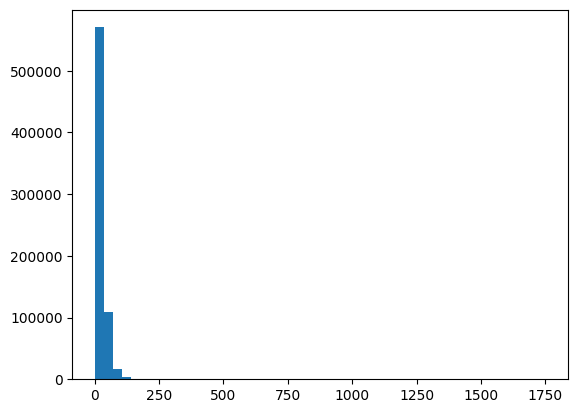

In [25]:
print(len(num_sentencas_textos))
n, bins, patches = plt.hist(num_sentencas_textos, 50, density=False)